## Applications of satellite gravimetry 

In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
from shapely.vectorized import contains

In [3]:
dsgrd = xr.open_dataset("TWS.nc")
dsgrd

<xarray.Dataset>
Dimensions:   (time: 162, lat: 181, lon: 361)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
  * lat       (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon       (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    tws       (lat, lon, time) float64 ...
    twsgauss  (lat, lon, time) float64 ...
    twsddk    (lat, lon, time) float64 ...

## read basins

In [4]:
data_dir = "data/basins"
#"GREENLAND.shp", ,"CONGO.gpkg","DANUBE.gpkg","INDUS.gpkg","NILE.gpkg", "RHINE.gpkg"
#basin_files = ["AMAZONAS.gpkg","CONGO.gpkg","DANUBE.gpkg","INDUS.gpkg","NILE.gpkg", "RHINE.gpkg"]
basin_files = ["RHINE.gpkg"]

In [5]:
for basin_file in basin_files:
    # Read the shapefile or geopackage
    fullpath = f"{data_dir}/{basin_file}"
    basin = gpd.read_file(fullpath)

    basin_name = basin.name[0]

basin_name

'RHINE'

In [6]:
def basin_grid_points(basin, resolution, buffer):
    averaging_kernel1=[]
    averaging_kernel1 = []  
    Basin_PFAF_ID = [] 
    

    for index in range(len(basin.geometry)):
        geom= basin.geometry.iloc[index]
        if geom.geom_type == 'Polygon':
            points = np.array(geom.exterior.coords[:-1]) 
            Basin_ids = basin['name'].iloc[0] 

            x_min, x_max = int(np.min(points[:, 0])) - buffer, int(np.max(points[:, 0])) + buffer
            y_min, y_max = int(np.min(points[:, 1])) - buffer, int(np.max(points[:, 1])) + buffer

        elif geom.geom_type == 'MultiPolygon':
            all_points = []
            for polygon in geom.geoms:
                points = np.array(polygon.exterior.coords[:-1])  
                all_points.extend(points)  

            all_points = np.array(all_points)
            Basin_ids = basin['name'].iloc[0]


            x_min, x_max = int(np.min(all_points[:, 0])) - buffer, int(np.max(all_points[:, 0])) + buffer
            y_min, y_max = int(np.min(all_points[:, 1])) - buffer, int(np.max(all_points[:, 1])) + buffer


        x = np.arange(x_min, x_max, resolution)
        y = np.arange(y_min, y_max, resolution)


        X, Y = np.meshgrid(x, y)


        grid_points = np.column_stack([X.ravel(), Y.ravel()]) ## Creates a 2D matrix
        
        
        mask1 = contains(geom, grid_points[:, 0], grid_points[:, 1]) #1D array source: https://regionmask.readthedocs.io/en/v0.6.1/notebooks/method.html

        Basin_PFAF_ID.append(Basin_ids) 
        inside_points = grid_points[mask1]

        
        ds_basin = xr.Dataset(coords = dict(lat = ("lat", inside_points[:,1]), lon = ("lon", inside_points[:,0])))


        print(Basin_PFAF_ID)
        
        averaging_kernel1.append(ds_basin)
        averaging_kernel = xr.concat(averaging_kernel1, dim="basin").assign_coords(basin=("basin", Basin_PFAF_ID))

        return ds_basin

In [7]:
resolution = 1
buffer = 5


coordinates_list = []

for basin_file in basin_files:
    
    fullpath = os.path.join(data_dir, basin_file)
    basin = gpd.read_file(fullpath)
    
    inside_points = basin_grid_points(basin, resolution, buffer)
    
    coordinates_list.append(inside_points)

coordinates_list   

#coordinates_all_basins = xr.concat(coordinates_list, dim = "name")

['RHINE']


[<xarray.Dataset>
 Dimensions:  (lat: 23, lon: 23)
 Coordinates:
   * lat      (lat) int64 47 47 47 47 48 48 49 49 49 ... 50 50 51 51 51 51 52 52
   * lon      (lon) int64 7 8 9 10 7 8 6 7 8 9 5 6 7 8 9 10 11 6 7 8 9 5 6
 Data variables:
     *empty*]

In [8]:
latt = coordinates_list[0].coords['lat'].values.astype(int)
lonn = coordinates_list[0].coords['lon'].values.astype(int)


In [9]:
dseries=dsgrd.sel(lon=lonn,lat=latt)

In [10]:
dseries

<xarray.Dataset>
Dimensions:   (time: 162, lat: 23, lon: 23)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
  * lat       (lat) float64 47.0 47.0 47.0 47.0 48.0 ... 51.0 51.0 52.0 52.0
  * lon       (lon) float64 7.0 8.0 9.0 10.0 7.0 8.0 ... 6.0 7.0 8.0 9.0 5.0 6.0
Data variables:
    tws       (lat, lon, time) float64 ...
    twsgauss  (lat, lon, time) float64 ...
    twsddk    (lat, lon, time) float64 ...

In [13]:
weights = np.cos(np.deg2rad(dseries.lat))
weights.name = "weights"

In [14]:
tws_weighted = dseries.weighted(weights)
tws_weighted

DatasetWeighted with weights along dimensions: lat

In [15]:
tws_weighted_mean = tws_weighted.mean(("lon", "lat")) #Each data point in dseries is multiplied by the corresponding weight in weights #source: https://docs.xarray.dev/en/latest/examples/area_weighted_temperature.html
tws_weighted_mean

<xarray.Dataset>
Dimensions:   (time: 162)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Data variables:
    tws       (time) float64 0.9376 -1.674 -0.1753 ... -1.582 -0.4379 0.636
    twsgauss  (time) float64 0.05665 0.03778 0.03439 ... -0.00796 -0.1357
    twsddk    (time) float64 0.009347 0.04964 0.042 ... 0.03123 -0.03756 -0.1542

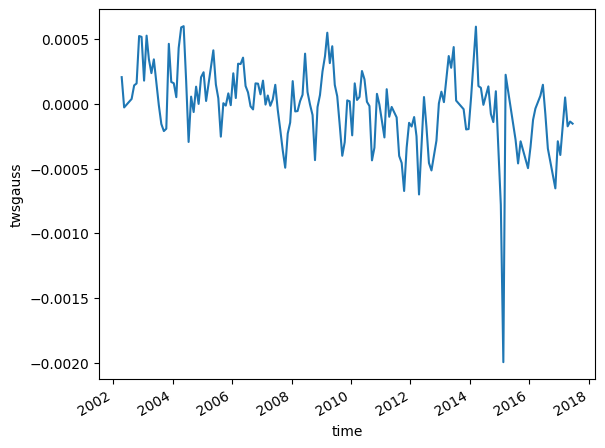

In [23]:
ds = tws_weighted_mean.twsgauss- dseries.mean(("lon", "lat")).twsgauss
ds.plot()

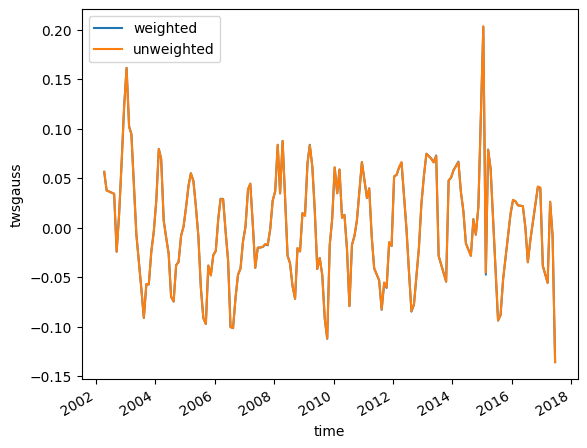

In [21]:
ds = tws_weighted_mean.twsgauss.plot(label="weighted") - dseries.mean(("lon", "lat")).twsgauss.plot(label="unweighted")

plt.legend()

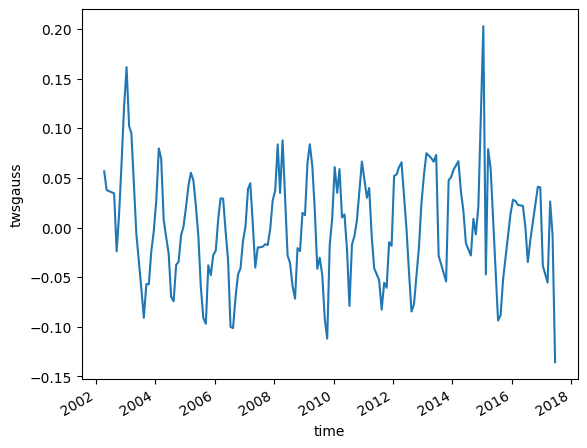

In [17]:
tws_weighted_mean.twsgauss.plot()

## Basins:


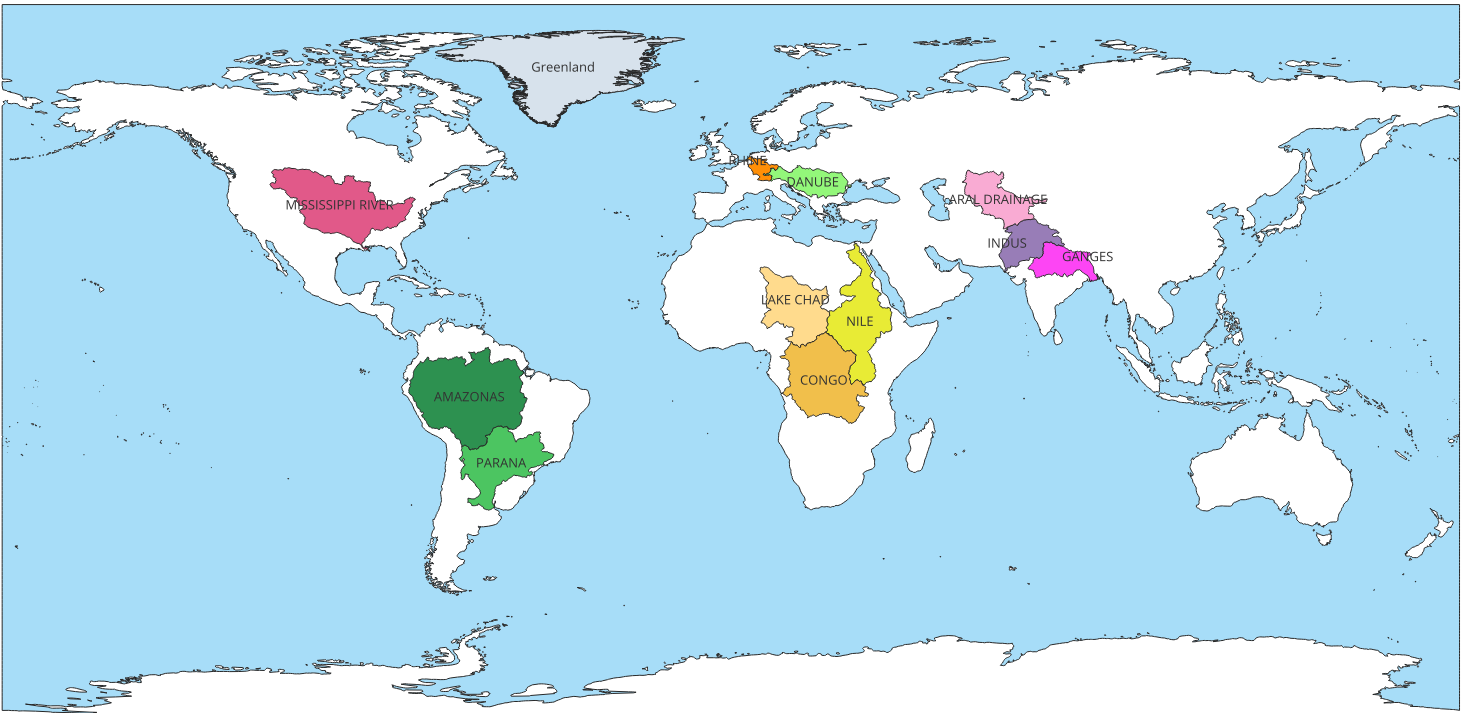

## Select three basins and create TWS time series. Explain what you see in these time series. Do you notice any differences between the locations? Try to find an explanation for what you are seeing.


## Explain the application of the TWS time series in your selected basins. Are there any specific extreme events that are happening? Do you think ice melting is occurring?

## Can you think of another application of the TWS time series that is not based on the selected basins?

## Choose one of the following questions to answer:

What are the impacts of climate change on water storage?

How can groundwater be monitored using GRACE data?